# Learning XOR with an Optical network with self-Kerr nonlinearities
### Comparing different nonlinearity strengths and initial conditions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(11) # random seed

def rk4_step(f, y, t, dt, args):
    """Performs a single step of the 4th-order Runge-Kutta method for solving ODEs."""
    k1 = f(t, y, args)
    k2 = f(t + 0.5 * dt, y + 0.5 * dt * k1 * dt, args)
    k3 = f(t + 0.5 * dt, y + 0.5 * dt * k2 * dt, args)
    k4 = f(t + dt, y + k3 * dt, args)
    
    return y + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

def solve_rk4(f, y0, t_span, dt, args):
    """Solves an ODE using RK4 over a time range."""
    t_values = np.arange(t_span[0], t_span[1] + dt, dt)
    y_values = []
    y_values.append(y0)
    
    for i in range(1, len(t_values)):
        y_values.append(rk4_step(f, y_values[i-1], t_values[i-1], dt, args))
    
    return t_values, np.array(y_values)

In [ ]:
# XOR Dataset
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
targets = np.array([0, 1, 1, 0])

# Parameters
N = 3 # Number of nodes
kappa = np.ones(N)  # Decay rates
g = .0  # Nonlinearity

# For small N (<10), even with a good gradient approx., the method may get stuck
# in bad local minima. The outcome strongly depends on the random initial params.
# This is an example of good initialization:
initial_J = np.array([[ 1.74945474, -1.46969578, -0.51059725],
                    [-1.46969578, -0.00828463, -0.00211435],
                    [-0.51059725, -0.00211435,  0.42105072]])

# Random initial weights:
#initial_J = np.random.randn(N, N)  # Connectivity matrix
#initial_J = (initial_J + initial_J.T) / 2

beta = 1e-3  # Perturbation magnitude

# Initialize state
y0 = np.random.randn(N) + 1j * np.random.randn(N)
a_in = np.random.randn(N) + 1j * np.random.randn(N)

# System dynamics
def system(t, a, args):
    kappa, g, J, a_in = args
    N = len(kappa)
    dadt = -0.5 * kappa * a - 1j * J @ a - g * 1j * a**2 * a.conj() - np.sqrt(kappa) * a_in
    return dadt

t_span = (0, 60)
dt = 0.01

# Training

In [6]:
weights = []

# Training loop
num_epochs = 200
# Learning rate
learning_rate = 0.001

losses = []

g_values = [0., 0.1, 0.2]

for g in g_values:
    loss_history = [] # Loss history
    J = initial_J.copy()
    
    for epoch in range(num_epochs):  # Number of epochs
        epoch_loss = 0
        for input_vec, target in zip(inputs, targets):
            # Set inputs
            a_in = np.zeros(N) + 1j * np.zeros(N)
            a_in[:2] = input_vec + 1j * 0.

            # Inference Phase:

            _, steady_state = solve_rk4(system, y0, t_span, dt, args=(kappa, g, J, a_in))
            a_out = a_in + (kappa)**0.5 * steady_state[-1]
            y = 10*a_out[2].real
            y0 = steady_state[-1] # update initial condition of the IVP

            # Compute loss for the current sample
            loss = (y - target)**2    
            epoch_loss += loss

            # Feedback Phase:

            # Compute error signal 
            delta_a_in = np.zeros(N) + 1j * np.zeros(N)
            delta_a_in[2] = -1j * beta * 10 * (y - target) # if U = sigma_y
            #delta_a_in[2] = beta * (y - target) # if U = sigma_x
            
            a_in += delta_a_in
            _, perturbed_steady_state = solve_rk4(system, y0, t_span, dt, args=(kappa, g, J, a_in))

            delta_a_out = (a_in + (kappa)**0.5 * perturbed_steady_state[-1]) - a_out

            y0 = steady_state[-1] # update initial condition of the IVP

            # Update weights
            for j in range(N):
                for l in range(N):
                        dJ_jl = - 2/(kappa[j]*kappa[l])**0.5 * ((a_out[l] - a_in[l])*(delta_a_out[j]-delta_a_in[j]) / beta + (a_out[j] - a_in[j])*(delta_a_out[l]-delta_a_in[l]) / beta).real # if U = sigma_y
                        #dJ_jl = -2/(kappa[j]*kappa[l])**0.5 * ((a_out[l] - a_in[l])*(delta_a_out[j]-delta_a_in[j]) / beta + (a_out[j] - a_in[j])*(delta_a_out[l]-delta_a_in[l]) / beta).imag # if U = sigma_x
                        if j == l:
                            dJ_jl = - 2/kappa[j] * ( (a_out[j] - a_in[j])*(delta_a_out[j]-delta_a_in[j]) / beta ).real # if U = sigma_y
                            #dJ_jl = -2/kappa[j] * ( (a_out[j] - a_in[j])*(delta_a_out[j]-delta_a_in[j]) / beta ).imag # if U = sigma_x
                            dJ_jl /= 2
                        J[j,l] -= learning_rate * dJ_jl
                        J[l,j] -= learning_rate * dJ_jl 


        # Average loss for the epoch
        epoch_loss = epoch_loss / len(inputs)
        loss_history.append(epoch_loss)

    weights.append(J.copy())
    losses.append(loss_history.copy())


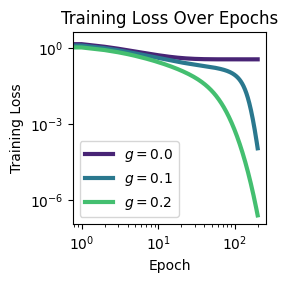

In [7]:
# Plot the losses' graph

colors = plt.cm.viridis(np.linspace(0.1, 0.7, 3))

plt.figure(figsize=(2.5, 2.5))
plt.plot(losses[0], color = colors[0], label=r'$g=0.0$', linewidth = 3)
plt.plot(losses[1], color = colors[1], label=r'$g=0.1$',linewidth = 3)
plt.plot(losses[2], color = colors[2], label=r'$g=0.2$',linewidth = 3)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.yscale('log')
plt.yticks([1e-0, 1e-3, 1e-6])
plt.xscale('log')
plt.show()

# Inference performance (of a trained network) depending on different initial conditions for the IVP

In [ ]:
N_samples = 100  # number of random initial conditions
errors = [] # MSE errors obtained for different g_values and initial conditions
t_span = (0, 60)

for i, g in enumerate(g_values):
    err = []
    J = weights[i]
    for i in range(N_samples):
        y0 = np.random.randn(N) + 1j * np.random.randn(N)
        epoch_loss = 0
        for input_vec, target in zip(inputs, targets):
            # Set inputs
            a_in = np.zeros(N) + 1j * np.zeros(N)
            a_in[:2] = input_vec + 1j * 0.

            # Inference Phase
            _, steady_state = solve_rk4(system, y0, t_span, dt, args=(kappa, g, J, a_in))
            a_out = a_in + (kappa)**0.5 * steady_state[-1]
            y = 10*a_out[2].real

            # Compute loss for the current sample
            loss = (y - target)**2    
            epoch_loss += loss
        err.append(epoch_loss / len(input_vec))
    errors.append(err)


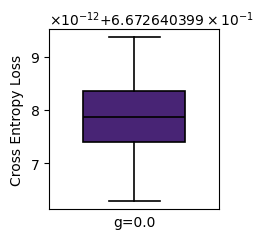

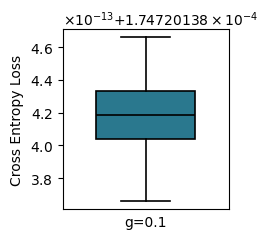

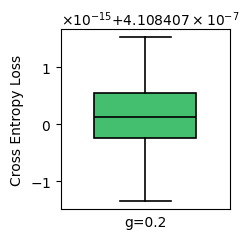

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

colors = plt.cm.viridis(np.linspace(0.1, 0.7, 3))

for i, err in enumerate(errors):
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    box = ax.boxplot(err, patch_artist=True, widths=0.6, showfliers=False)

    # Color the box
    for patch in box['boxes']:
        patch.set_facecolor(colors[i])
        patch.set_edgecolor('black')
        patch.set_linewidth(1.2)

    # Style the rest
    for element in ['whiskers', 'caps', 'medians']:
        for item in box[element]:
            item.set(color='black', linewidth=1.2)
    for flier in box['fliers']:
        flier.set(marker='o', color='gray', alpha=0.5)

    ax.set_ylabel("Cross Entropy Loss")
    ax.set_xlabel(f"g={g_values[i]}")
    ax.set_xticks([])

    # Scientific notation for y-axis
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.tight_layout()
    plt.show()


# Network's weights before and after training

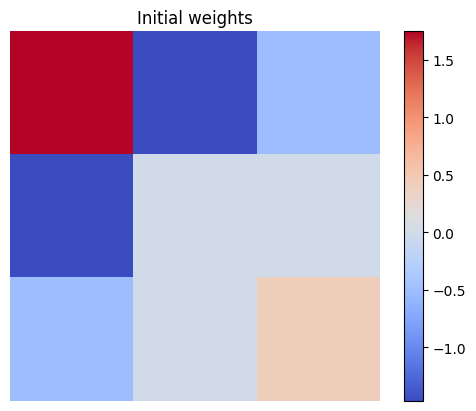

In [ ]:
plt.imshow(initial_J, cmap='coolwarm', interpolation='nearest')
plt.colorbar()  # Optional: Adds a color bar to the side to show value mapping
plt.title(r"Initial weights")
vmin = np.min(weights)
vmax = np.max(weights)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()

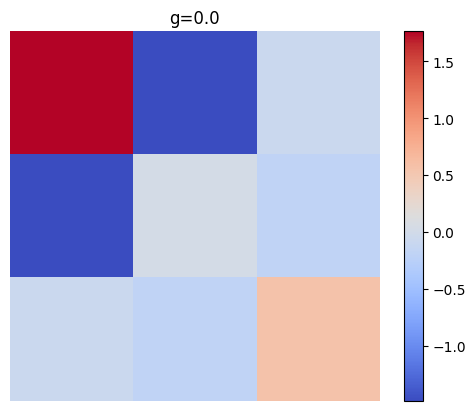

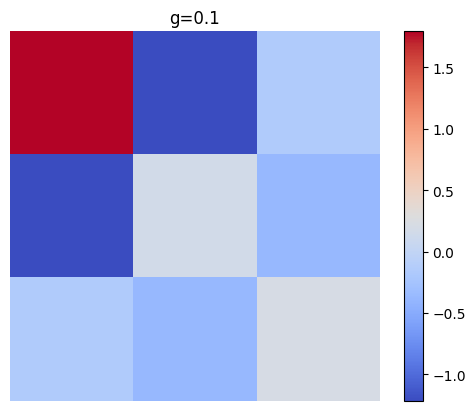

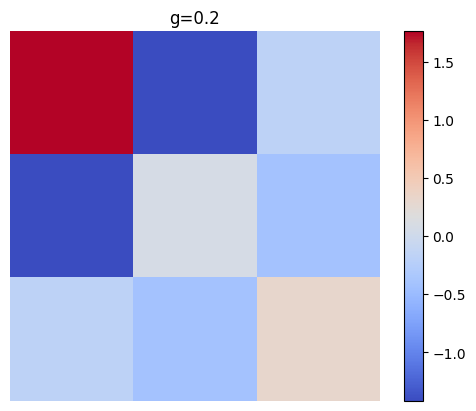

In [11]:
for i in range(len(weights)):
    plt.imshow(weights[i], cmap='coolwarm', interpolation='nearest')  # 'viridis' is a good colormap for intensity
    plt.colorbar()  # Optional: Adds a color bar to the side to show value mapping
    plt.title(f"g={g_values[i]}")
    vmin = np.min(weights)
    vmax = np.max(weights)
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()